In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "double"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [26]:
# define simulation parameters
from simulation.config import Config
config = Config(dims=[1000], dt = 1e-3, mass_real = -2*(np.cos(np.pi/3)+1j*np.sin(np.pi/3)), interaction=6*2)
n_steps = int(1e4)

# create simulation instance
from simulation.cl_simulation import ComplexLangevinSimulation
sim = ComplexLangevinSimulation(config)

# define kernel bridge with kernels defining the theory
from src.utils import noise_kernel, evolve_kernel, mexican_hat_kernel_real, KernelBridge
kernel_br = KernelBridge(sim, [noise_kernel, evolve_kernel, mexican_hat_kernel_real], const_param={})

# register observable
from src.obs_kernels import n_moment_kernel
sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True)

# init arguments
args = kernel_br.get_current_params()

# start the loop 
from tqdm import tqdm
for k in tqdm(range(n_steps)):
    sim.update_noise(noise_kernel, *args[noise_kernel].values())
    sim.update_drift(mexican_hat_kernel_real, *args[mexican_hat_kernel_real].values())
    args = kernel_br.get_current_params()
    sim.set_apative_stepsize()
    sim.update_field(evolve_kernel, *args[evolve_kernel].values())
    sim.swap()

    if np.any(np.isnan(sim.phi0)): print('break'); break
    if sim.langevin_time > 5: sim.compute('1_moment')

sim.finish()

100%|██████████| 10000/10000 [00:05<00:00, 1793.09it/s]


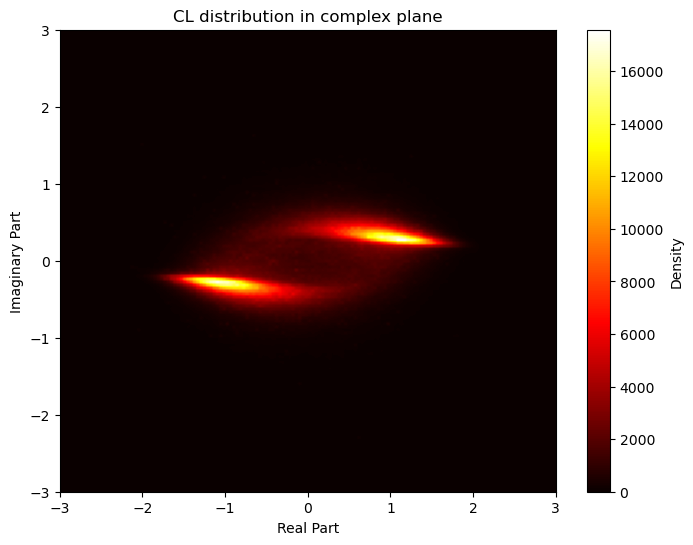

In [ ]:
data = sim.trackers['1_moment'].history

magnitudes = np.abs(data)
data = data[magnitudes <= 10]   
real_parts, imag_parts = data.real, data.imag
bins = 500
heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(
    heatmap.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin='lower',
    cmap='hot',
    aspect='auto'
)

plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.colorbar(label='Density')
plt.title('CL distribution in complex plane')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(visible=False)
plt.show()